# Causal Inference

In [115]:
#Installing libraries and packages

In [116]:
pip install dowhy

In [117]:
conda install -c conda-forge dowhy

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [118]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [119]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
import dowhy.api
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [120]:
clv = pd.read_csv(r"C:\Users\Nupur\OneDrive - McGill University\Desktop\McGill Notes\INSY695075\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

In [121]:
clv_clean = clv.drop(columns=["Customer","Effective To Date","Policy Type"])

In [122]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,...,32,5,0,1,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,...,13,42,0,8,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,...,18,38,0,2,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,...,18,65,0,7,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,...,12,44,0,1,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [123]:
clv.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Customer             9134
State                   5
Response                2
Coverage                3
Education               5
Effective To Date      59
EmploymentStatus        5
Gender                  2
Location Code           3
Marital Status          3
Policy Type             3
Policy                  9
Renew Offer Type        4
Sales Channel           4
Vehicle Class           6
Vehicle Size            3
dtype: int64

In [124]:
#Splitting Features into binary and remaining categorical

binary_feature = clv_clean.nunique()[clv_clean.nunique() == 2].keys().tolist()

In [125]:
categorical_feature = [col for col in clv_clean.select_dtypes('object').columns.to_list() if col not in binary_feature]

In [126]:
categorical_feature

['State',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Location Code',
 'Marital Status',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size']

In [127]:
# Feature Engineering  - dummyfying the binary and categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in binary_feature:
    clv_clean[i] = le.fit_transform(clv_clean[i])

In [128]:
clv_clean.columns

Index(['State', 'Customer Lifetime Value', 'Response', 'Coverage', 'Education',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy', 'Renew Offer Type', 'Sales Channel',
       'Total Claim Amount', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [131]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,0,Basic,Bachelor,Employed,False,56274,Suburban,Married,...,32,5,0,1,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,0,Extended,Bachelor,Unemployed,False,0,Suburban,Single,...,13,42,0,8,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,0,Premium,Bachelor,Employed,False,48767,Suburban,Married,...,18,38,0,2,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,0,Basic,Bachelor,Unemployed,True,0,Suburban,Married,...,18,65,0,7,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,0,Basic,Bachelor,Employed,True,43836,Rural,Single,...,12,44,0,1,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


**Creating Causal Models with Treatment and control features and target variable**

**Treatment - Gender**

In [135]:
clv_clean['Gender'] = clv_clean['Gender'].apply(bool)
clv_clean['Response'] = clv_clean['Response'].apply(bool)

In [153]:
clv_clean.dtypes

State                             object
Customer Lifetime Value          float64
Response                            bool
Coverage                          object
Education                         object
EmploymentStatus                  object
Gender                              bool
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy                            object
Renew Offer Type                  object
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size                      object
propensity_score                 float64
strata                           float64
dbar                               int32
d_y             

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Gender'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


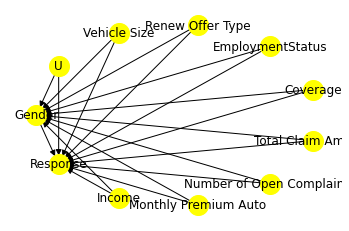

In [140]:
model1= CausalModel(
        data=clv_clean,
        treatment='Gender',
        outcome="Response",
        common_causes=['Income','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Renew Offer Type','Vehicle Size','Number of Policies'])
model1.view_model()

In [141]:
identified_estimand1 = model1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand1)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
    d                                                                         
─────────(Expectation(Response|Monthly Premium Auto,Income,Number of Open Comp
d[Gender]                                                                     

                                                                              
laints,EmploymentStatus,Vehicle Size,Coverage,Renew Offer Type,Total Claim Amo
                                                                              

     
unt))
     
Estimand assumption 1, Unconfoundedness: If U→{Gender} and U→Response then P(Response|Gender,Monthly Premium Auto,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,Coverage,Renew Offer Type,Total Claim Amount,U) = P(Response|Gender,Monthly Premium Auto,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,Coverage,Renew Offer Type,Total Claim Amount)

### Estimand : 2
Estima

In [142]:
causal_estimate1 = model1.estimate_effect(identified_estimand1,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate1)
print("Causal Estimate is " + str(causal_estimate1.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Response~Gender+Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Coverage+Renew Offer Type+Total Claim Amount
C:\Users\Nupur\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Nupur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Gender+Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Coverage+Renew Offer Type+Total Claim Amount
Target units: ate

## Estimate
Mean value: 0.0020789485370343933

Causal Estimate is 0.0020789485370343933


**Treatment - Income**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Income'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


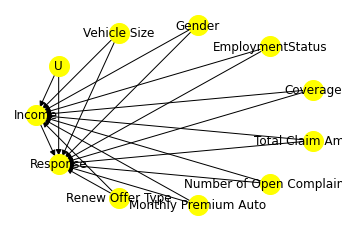

In [150]:
model2= CausalModel(
        data=clv_clean,
        treatment='Income',
        outcome="Response",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies'])
model2.view_model()

In [151]:
identified_estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand2)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
    d                                                                         
─────────(Expectation(Response|Monthly Premium Auto,Number of Open Complaints,
d[Income]                                                                     

                                                                              
EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amo
                                                                              

     
unt))
     
Estimand assumption 1, Unconfoundedness: If U→{Income} and U→Response then P(Response|Income,Monthly Premium Auto,Number of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amount,U) = P(Response|Income,Monthly Premium Auto,Number of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amount)

### Estimand : 2
Estima

In [152]:
causal_estimate2 = model2.estimate_effect(identified_estimand2,
        method_name="backdoor.linear_regression")
print(causal_estimate2)
print("Causal Estimate is " + str(causal_estimate2.value))

INFO:dowhy.causal_estimator:b: Response~Income+Monthly Premium Auto+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Income+Monthly Premium Auto+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
Target units: ate

## Estimate
Mean value: 1.391928165506151e-07

Causal Estimate is 1.391928165506151e-07


**Treatment - Monthly Premium Auto**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Monthly Premium Auto'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


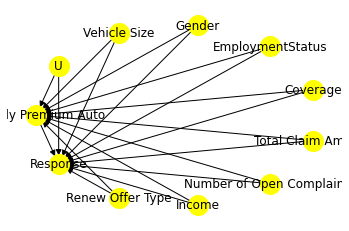

In [154]:
model3= CausalModel(
        data=clv_clean,
        treatment='Monthly Premium Auto',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies'])
model3.view_model()

In [155]:
identified_estimand3 = model3.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand3)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
           d                                                                  
───────────────────────(Expectation(Response|Income,Number of Open Complaints,
d[Monthly Premium Auto]                                                       

                                                                              
EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amo
                                                                              

     
unt))
     
Estimand assumption 1, Unconfoundedness: If U→{Monthly Premium Auto} and U→Response then P(Response|Monthly Premium Auto,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amount,U) = P(Response|Monthly Premium Auto,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amount)

### Estim

In [156]:
causal_estimate3 = model3.estimate_effect(identified_estimand3,
        method_name="backdoor.linear_regression")
print(causal_estimate3)
print("Causal Estimate is " + str(causal_estimate3.value))

INFO:dowhy.causal_estimator:b: Response~Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
Target units: ate

## Estimate
Mean value: -2.0867015925296606e-05

Causal Estimate is -2.0867015925296606e-05


**Treatment - Number of Open Complaints**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Number of Open Complaints'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


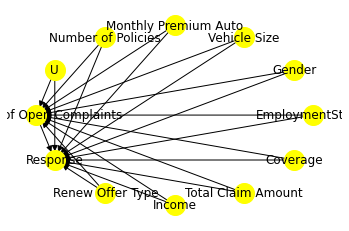

In [160]:
model5= CausalModel(
        data=clv_clean,
        treatment='Number of Open Complaints',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Monthly Premium Auto','Number of Policies'])
model5.view_model()

In [161]:
identified_estimand5 = model5.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand5)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
             d                                                                
────────────────────────────(Expectation(Response|Monthly Premium Auto,Total C
d[Number of Open Complaints]                                                  

                                                                              
laim Amount,Income,EmploymentStatus,Coverage,Gender,Vehicle Size,Renew Offer T
                                                                              

                        
ype,Number of Policies))
                        
Estimand assumption 1, Unconfoundedness: If U→{Number of Open Complaints} and U→Response then P(Response|Number of Open Complaints,Monthly Premium Auto,Total Claim Amount,Income,EmploymentStatus,Coverage,Gender,Vehicle Size,Renew Offer Type,Number of Policies,U) = P(Response|Number of Open Complaints,Monthly Premium Auto,Total Claim Amount,

In [162]:
causal_estimate5 = model5.estimate_effect(identified_estimand5,
        method_name="backdoor.linear_regression")
print(causal_estimate5)
print("Causal Estimate is " + str(causal_estimate5.value))

INFO:dowhy.causal_estimator:b: Response~Number of Open Complaints+Monthly Premium Auto+Total Claim Amount+Income+EmploymentStatus+Coverage+Gender+Vehicle Size+Renew Offer Type+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Number of Open Complaints+Monthly Premium Auto+Total Claim Amount+Income+EmploymentStatus+Coverage+Gender+Vehicle Size+Renew Offer Type+Number of Policies
Target units: ate

## Estimate
Mean value: -0.0020969154181967875

Causal Estimate is -0.0020969154181967875


**Treatment - Number of Policies**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Number of Policies'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


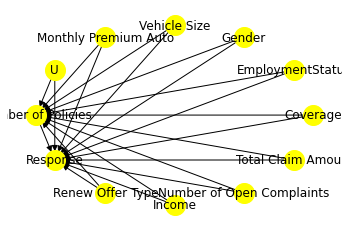

In [163]:
model6= CausalModel(
        data=clv_clean,
        treatment='Number of Policies',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Monthly Premium Auto'])
model6.view_model()

In [164]:
identified_estimand6 = model6.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand6)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
          d                                                                   
─────────────────────(Expectation(Response|Monthly Premium Auto,Income,Number 
d[Number of Policies]                                                         

                                                                              
of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer T
                                                                              

                        
ype,Total Claim Amount))
                        
Estimand assumption 1, Unconfoundedness: If U→{Number of Policies} and U→Response then P(Response|Number of Policies,Monthly Premium Auto,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Total Claim Amount,U) = P(Response|Number of Policies,Monthly Premium Auto,Income,Number of Open Complaints,

In [165]:
causal_estimate6 = model6.estimate_effect(identified_estimand6,
        method_name="backdoor.linear_regression")
print(causal_estimate6)
print("Causal Estimate is " + str(causal_estimate6.value))

INFO:dowhy.causal_estimator:b: Response~Number of Policies+Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Number of Policies+Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
Target units: ate

## Estimate
Mean value: -0.0023436360299293746

Causal Estimate is -0.0023436360299293746


**Treatment - Total Claim Amount**

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Total Claim Amount'] on outcome ['Response']
INFO:dowhy.causal_graph:Using Matplotlib for plotting


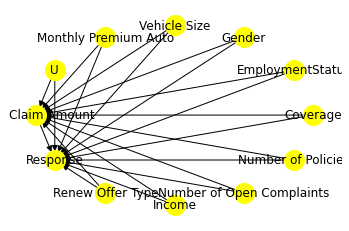

In [166]:
model7= CausalModel(
        data=clv_clean,
        treatment='Total Claim Amount',
        outcome="Response",
        common_causes=['Renew Offer Type','Income','Number of Open Complaints','Number of Policies','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Monthly Premium Auto'])
model7.view_model()

In [167]:
identified_estimand7 = model7.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand7)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
          d                                                                   
─────────────────────(Expectation(Response|Monthly Premium Auto,Income,Number 
d[Total Claim Amount]                                                         

                                                                              
of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer T
                                                                              

                        
ype,Number of Policies))
                        
Estimand assumption 1, Unconfoundedness: If U→{Total Claim Amount} and U→Response then P(Response|Total Claim Amount,Monthly Premium Auto,Income,Number of Open Complaints,EmploymentStatus,Vehicle Size,Gender,Coverage,Renew Offer Type,Number of Policies,U) = P(Response|Total Claim Amount,Monthly Premium Auto,Income,Number of Open Complaints,

In [168]:
causal_estimate7 = model7.estimate_effect(identified_estimand4,
        method_name="backdoor.linear_regression")
print(causal_estimate7)
print("Causal Estimate is " + str(causal_estimate7.value))

INFO:dowhy.causal_estimator:b: Response~Months Since Last Claim+Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Months Since Last Claim+Monthly Premium Auto+Income+Number of Open Complaints+EmploymentStatus+Vehicle Size+Gender+Coverage+Renew Offer Type+Total Claim Amount
Target units: ate

## Estimate
Mean value: 1.919591687590816e-05

Causal Estimate is 1.919591687590816e-05
